In [1]:
%matplotlib inline

from __future__ import absolute_import, print_function, unicode_literals, division
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import random as rand
import copy

In [2]:
#Obtain complete MNIST images
DATA_PATH = '~/data'
mnist = fetch_mldata('MNIST original', data_home=DATA_PATH)

subset = mnist.data[:100]

#Convert to binary matrix 
for img in subset:
    img[img < 100] = 0
    img[img > 0] = 1

In [15]:
from __future__ import print_function
import numpy as np

class RBM:
  
  def __init__(self, num_visible, num_hidden, learning_rate = 0.1):
    self.num_hidden = num_hidden
    self.num_visible = num_visible
    self.learning_rate = learning_rate

    # Initialize a weight matrix, of dimensions (num_visible x num_hidden), using
    # a Gaussian distribution with mean 0 and standard deviation 0.1.
    self.weights = 0.1 * np.random.randn(self.num_visible, self.num_hidden)    
    # Insert weights for the bias units into the first row and first column.
    self.weights = np.insert(self.weights, 0, 0, axis = 0)
    self.weights = np.insert(self.weights, 0, 0, axis = 1)
    print(self.weights.shape)

  def train(self, data, max_epochs = 1000):
    """
    Train the machine.
    Parameters
    ----------
    data: A matrix where each row is a training example consisting of the states of visible units.    
    """

    num_examples = data.shape[0]

    # Insert bias units of 1 into the first column.
    data = np.insert(data, 0, 1, axis = 1)

    for epoch in range(max_epochs):      
      # Clamp to the data and sample from the hidden units. 
      # (This is the "positive CD phase", aka the reality phase.)
      pos_hidden_activations = np.dot(data, self.weights)      
      pos_hidden_probs = self._logistic(pos_hidden_activations)
      pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
      # Note that we're using the activation *probabilities* of the hidden states, not the hidden states       
      # themselves, when computing associations. We could also use the states; see section 3 of Hinton's 
      # "A Practical Guide to Training Restricted Boltzmann Machines" for more.
      pos_associations = np.dot(data.T, pos_hidden_probs)

      # Reconstruct the visible units and sample again from the hidden units.
      # (This is the "negative CD phase", aka the daydreaming phase.)
      neg_visible_activations = np.dot(pos_hidden_states, self.weights.T)
      neg_visible_probs = self._logistic(neg_visible_activations)
      neg_visible_probs[:,0] = 1 # Fix the bias unit.
      neg_hidden_activations = np.dot(neg_visible_probs, self.weights)
      neg_hidden_probs = self._logistic(neg_hidden_activations)
      # Note, again, that we're using the activation *probabilities* when computing associations, not the states 
      # themselves.
      neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

      # Update weights.
      self.weights += self.learning_rate * ((pos_associations - neg_associations) / num_examples)

      error = np.sum((data - neg_visible_probs) ** 2)
      print("Epoch %s: error is %s" % (epoch, error))
      if epoch == 10: 
            return neg_visible_probs

  def run_visible(self, data):
    """
    Assuming the RBM has been trained (so that weights for the network have been learned),
    run the network on a set of visible units, to get a sample of the hidden units.
    
    Parameters
    ----------
    data: A matrix where each row consists of the states of the visible units.
    
    Returns
    -------
    hidden_states: A matrix where each row consists of the hidden units activated from the visible
    units in the data matrix passed in.
    """
    
    num_examples = data.shape[0]
    
    # Create a matrix, where each row is to be the hidden units (plus a bias unit)
    # sampled from a training example.
    hidden_states = np.ones((num_examples, self.num_hidden + 1))
    
    # Insert bias units of 1 into the first column of data.
    data = np.insert(data, 0, 1, axis = 1)

    # Calculate the activations of the hidden units.
    hidden_activations = np.dot(data, self.weights)
    # Calculate the probabilities of turning the hidden units on.
    hidden_probs = self._logistic(hidden_activations)
    # Turn the hidden units on with their specified probabilities.
    hidden_states[:,:] = hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
    # Always fix the bias unit to 1.
    # hidden_states[:,0] = 1
  
    # Ignore the bias units.
    hidden_states = hidden_states[:,1:]
    return hidden_states
    
  # TODO: Remove the code duplication between this method and `run_visible`?
  def run_hidden(self, data):
    """
    Assuming the RBM has been trained (so that weights for the network have been learned),
    run the network on a set of hidden units, to get a sample of the visible units.
    Parameters
    ----------
    data: A matrix where each row consists of the states of the hidden units.
    Returns
    -------
    visible_states: A matrix where each row consists of the visible units activated from the hidden
    units in the data matrix passed in.
    """

    num_examples = data.shape[0]

    # Create a matrix, where each row is to be the visible units (plus a bias unit)
    # sampled from a training example.
    visible_states = np.ones((num_examples, self.num_visible + 1))

    # Insert bias units of 1 into the first column of data.
    data = np.insert(data, 0, 1, axis = 1)

    # Calculate the activations of the visible units.
    visible_activations = np.dot(data, self.weights.T)
    # Calculate the probabilities of turning the visible units on.
    visible_probs = self._logistic(visible_activations)
    # Turn the visible units on with their specified probabilities.
    visible_states[:,:] = visible_probs > np.random.rand(num_examples, self.num_visible + 1)
    # Always fix the bias unit to 1.
    # visible_states[:,0] = 1

    # Ignore the bias units.
    visible_states = visible_states[:,1:]
    return visible_states
    
  def daydream(self, num_samples):
    """
    Randomly initialize the visible units once, and start running alternating Gibbs sampling steps
    (where each step consists of updating all the hidden units, and then updating all of the visible units),
    taking a sample of the visible units at each step.
    Note that we only initialize the network *once*, so these samples are correlated.
    Returns
    -------
    samples: A matrix, where each row is a sample of the visible units produced while the network was
    daydreaming.
    """

    # Create a matrix, where each row is to be a sample of of the visible units 
    # (with an extra bias unit), initialized to all ones.
    samples = np.ones((num_samples, self.num_visible + 1))

    # Take the first sample from a uniform distribution.
    samples[0,1:] = np.random.rand(self.num_visible)

    # Start the alternating Gibbs sampling.
    # Note that we keep the hidden units binary states, but leave the
    # visible units as real probabilities. See section 3 of Hinton's
    # "A Practical Guide to Training Restricted Boltzmann Machines"
    # for more on why.
    for i in range(1, num_samples):
      visible = samples[i-1,:]

      # Calculate the activations of the hidden units.
      hidden_activations = np.dot(visible, self.weights)      
      # Calculate the probabilities of turning the hidden units on.
      hidden_probs = self._logistic(hidden_activations)
      # Turn the hidden units on with their specified probabilities.
      hidden_states = hidden_probs > np.random.rand(self.num_hidden + 1)
      # Always fix the bias unit to 1.
      hidden_states[0] = 1

      # Recalculate the probabilities that the visible units are on.
      visible_activations = np.dot(hidden_states, self.weights.T)
      visible_probs = self._logistic(visible_activations)
      visible_states = visible_probs > np.random.rand(self.num_visible + 1)
      samples[i,:] = visible_states

    # Ignore the bias units (the first column), since they're always set to 1.
    return samples[:,1:]        
      
  def _logistic(self, x):
    return 1.0 / (1 + np.exp(-x))

In [6]:
DATA_PATH = '~/data'
mnist = fetch_mldata('MNIST original', data_home=DATA_PATH)
print(mnist.data.shape)

(70000, 784)


In [7]:
data_array = mnist.data
print(data_array[0])
print(data_array.shape)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  51 159 253 159  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252
 253 122   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 163 252 252 252 253 252 252  96 189 253 167   

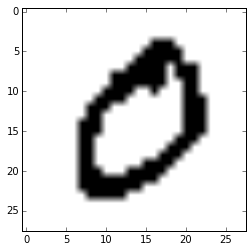

In [8]:
#Convert image to binary matrix
for img in data_array:
    img[img < 100] = 0
    img[img > 0] = 1

plt.imshow(data_array[0].reshape(28, 28), cmap = 'Greys')
plt.show()

In [ ]:
if __name__ == '__main__':
  r = RBM(num_visible = 784, num_hidden = 2)
  d = r.train(data_array, max_epochs = 11)
  print(r.weights)

In [14]:
plt.imshow(d[0].reshape(28, 28), cmap = 'Greys')
plt.show()

TypeError: 'NoneType' object has no attribute '__getitem__'